# Dueling Double DQN

_Ismaël Bonneau_


## Modèle & architecture

Comme indiqué dans le titre, ce modèle est une amélioration du **DQN**. Il reprend tous ses principes, comme le experience replay, le remplacement de la target tous les ${C}$ pas de temps, mais diffère en un point. 

Avec un **DQN**, notre réseau prend ${\phi(s)}$ en entrée et sort ${Q(s,a)}$ les valeurs des actions pour cet état ${s}$. Généralement, dans le cas d'un jeu, ${\phi(s)}$ correspond à un réseau de convolution (CNN).

Avec un **DDQN**, on prend ${\phi(s)}$ et on le traite avec 2 réseaux différents, pour produire deux sorties:
- ${V(s)}$ qui est la "valeur" de l'état, ou combien il est intéressant d'être dans cet état.
- ${A(s, a)}$ qui est la fonction avantage (rappel: <a href="">actor-critic</a>) et qui indique combien il est avantageux, quand on se trouve dans l'état ${s}$, d'effectuer l'action ${a}$ par rapport aux autres actions.

Ces deux valeurs son ensuite combinées pour former ${Q(s,a)}$. On n'utilise pas la somme pour combiner les deux (ce qui normalement est bien la formule: ${Q(s,a) = V(s) + A(s,a)}$ mais une autre formule, ${Q(s,a) = V(s) + (A(s,a) - \frac{1}{|A|} \sum_{a}{A(s,a)})}$. (Dire pourquoi)

### Architecture du réseau de neurones:

L'architecture du modèle est composée d'un premier réseau de convolution, qui va prendre en entrée les frames du jeu (généralement stackées par groupe, nous verrons ça plus tard)

<img src="images/dueling-q-network.png" width="600">

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Nous allons appliquer ce modèle sur un jeu bien connu, super Mario bros.

Ce jeu n'est pas disponible dans l'environnement gym par défaut. Il doit être installé à part (avec d'autres packages comme pyNes)

<img src="images/mario.gif" width="400">

In [2]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import pprint
pp = pprint.PrettyPrinter(indent=4)

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

frame shape:  (240, 256, 3)
game status: 
{   'coins': 0,
    'flag_get': False,
    'life': 2,
    'score': 0,
    'stage': 1,
    'status': 'small',
    'time': 400,
    'world': 1,
    'x_pos': 40,
    'x_pos_screen': 40,
    'y_pos': 79}


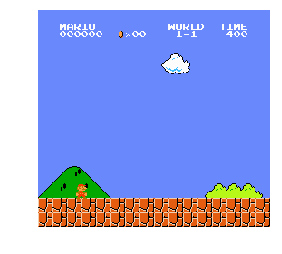

In [4]:
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())

print("frame shape: ", state.shape)
print("game status: ")
pp.pprint(info)
plt.imshow(state)
plt.axis('off')
plt.show()

## Commençons tous les pré-traitements préalables

Il faut commencer par traiter les frames. Comme on l'a vu, un état du jeu correspond à une frame de dimension ${(240, 256, 3)}$ (3 car en couleur). Il faut pré-traiter ces images pour les donner en entrée à un petit réseau de convolution ${\phi}$ qui produira ${\phi(s)}$

In [5]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

grey = rgb2gray(state)

#### Passage en noir et blanc:

On enlève de l'information inutile et on passe de ${(240, 256, 3)}$ à ${(240, 256)}$ (3 fois moins de valeurs).

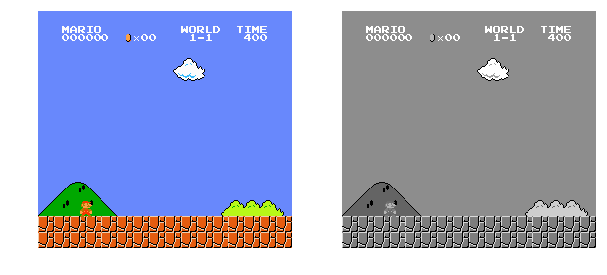

In [18]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.axis('off')
ax1.imshow(state)
ax2 = fig.add_subplot(1,2,2)
ax2.axis('off')
ax2.imshow(grey, cmap="gray")
plt.show()

Recadrage: on va "crop" l'image (on peut se débarasser du haut du ciel par exemple, avec le score et les vies) et redimensionner l'image qui est trop grande. Peut être se ramener à du ${(64, 64)}$?